In [3]:
def load_lan_file(filename, trunc_level):
    """
    Reads a .lan file and returns a list of levels truncated (or extended) to trunc_level.
    
    Each level is represented as a list of tuples (epsilon, critical_value).
    The file is assumed to use header lines (starting with '#' or '%') to indicate
    the beginning of a new level. The function stops reading new levels once trunc_level
    levels have been loaded. If the file contains fewer than trunc_level levels, the output
    list is extended with empty lists.
    
    Parameters:
      filename: path to the .lan file.
      trunc_level: integer specifying the desired number of levels.
      
    Returns:
      A list of length trunc_level. Each entry is a list of (epsilon, critical_value) tuples.
    """
    levels = []
    current_points = []
    current_level_count = 0

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # Skip empty lines
            if line.startswith('#') or line.startswith('%'):
                # Header encountered: if we already have accumulated points,
                # finish the previous level.
                if current_points:
                    levels.append(current_points)
                    current_points = []
                    current_level_count += 1
                    # Stop if we've reached the truncation limit.
                    if current_level_count == trunc_level:
                        break
                # Otherwise, it's just a header and we start a new level.
                continue
            # Only parse data if we haven't reached the truncation limit.
            if current_level_count < trunc_level:
                tokens = line.split()
                if len(tokens) != 2:
                    raise ValueError("Expected exactly two tokens per critical point line, got: " + str(tokens))
                eps = float(tokens[0])
                val = float(tokens[1])
                current_points.append((eps, val))
    
    # After finishing reading, add any remaining points as the last level if we haven't reached the limit.
    if current_points and current_level_count < trunc_level:
        levels.append(current_points)
        current_level_count += 1

    # If we still don't have enough levels, extend with empty lists.
    while current_level_count < trunc_level:
        levels.append([])
        current_level_count += 1

    return levels

# Example usage:
# filename = "1by7_A_1.lan"  # Replace with your file path
# desired_levels = 3         # For example, truncate (or extend) to 3 levels
# levels_data = load_lan_file(filename, desired_levels)

# # Each entry in levels_data is a list of (epsilon, critical_value) pairs.
# for i, level in enumerate(levels_data, start=1):
#     print(f"Level {i}:")
#     for pt in level:
#         print("  epsilon =", pt[0], ", value =", pt[1])


In [45]:
# Example usage:
filename = "ph-knotted-proteins/data/validation/landscapes/interpolated_x1/1by7_A_1.lan"  # Replace with your file path
desired_levels = 5         # For example, truncate (or extend) to 3 levels
levels_data = load_lan_file(filename, desired_levels)

# Each entry in levels_data is a list of (epsilon, critical_value) pairs.
# for i, level in enumerate(levels_data, start=1):
#     print(f"Level {i}:")
#     for pt in level:
#         print("  epsilon =", pt[0], ", value =", pt[1])

In [4]:
def eval_landscape(points, t):
    """
    Evaluates a landscape function (given as a list of critical points)
    at the point t by linear interpolation.
    
    The function is assumed to be 0 outside the range of the critical points.
    """
    if not points:
        return 0.0
    # t is outside the range of the critical points -> return 0.
    if t < points[0][0] or t > points[-1][0]:
        return 0.0
    # Find the interval [x0, x1] in which t lies.
    for i in range(1, len(points)):
        x0, y0 = points[i-1]
        x1, y1 = points[i]
        if x0 <= t <= x1:
            # if t is exactly a critical point, return its value
            if t == x0:
                return y0
            if t == x1:
                return y1
            # Linear interpolation
            return y0 + (y1 - y0) * (t - x0) / (x1 - x0)
    return 0.0

def create_time_series(levels, trunc_level):
    """
    Given a list of levels (each a list of (epsilon, value) tuples),
    creates a time series (as a NumPy array) with truncation/extension to trunc_level.
    
    The output is an array of shape (trunc_level+1, T), where T is the number
    of unique epsilon values across the first trunc_level levels.
    
    The last row contains the unique epsilon values (in ascending order).
    Each of the first trunc_level rows contains the evaluation of that level's
    landscape function at each epsilon value.
    """
    num_levels_in_file = len(levels)
    
    # If the file has fewer than trunc_level levels, extend with empty lists (interpreted as identically zero).
    if num_levels_in_file < trunc_level:
        for _ in range(trunc_level - num_levels_in_file):
            levels.append([])
    else:
        # Otherwise, only consider the first trunc_level levels.
        levels = levels[:trunc_level]
    
    # Collect all epsilon values from the levels.
    epsilon_set = set()
    for pts in levels:
        for (eps, _) in pts:
            epsilon_set.add(eps)
    epsilon_vals = sorted(epsilon_set)
    
    T = len(epsilon_vals)
    ts = np.zeros((trunc_level + 1, T))
    # The last row is simply the epsilon values.
    ts[trunc_level, :] = epsilon_vals
    
    # Evaluate each level's landscape function at each epsilon.
    for i, pts in enumerate(levels):
        for j, t in enumerate(epsilon_vals):
            ts[i, j] = eval_landscape(pts, t)
    return ts

In [47]:
# ----------------------------
# Example usage:
num_levels = 5
time_series = create_time_series(levels_data, num_levels)

print("Time-series array (each column is a time step):")
print(time_series)

Time-series array (each column is a time step):
[[0.000000e+00 3.300000e-04 4.854000e-02 9.206000e-02 1.165600e-01
  6.142350e-01 6.140700e-01 6.381750e-01 6.599350e-01 6.721850e-01
  6.756850e-01 8.111350e-01 8.298450e-01 8.823400e-01 9.045500e-01
  9.329550e-01 9.927600e-01 1.027220e+00 1.031045e+00 1.064175e+00
  1.088755e+00 1.108340e+00 1.160460e+00 1.136355e+00 1.192575e+00
  1.254110e+00 1.273695e+00 1.281870e+00 1.958360e+00 1.997830e+00
  2.066305e+00 2.085890e+00 2.133535e+00 2.190015e+00 2.550380e+00
  2.553925e+00 2.606860e+00 2.643190e+00 2.958010e+00 3.095335e+00
  3.131665e+00 3.146525e+00 3.203905e+00 3.062100e+00 3.000025e+00
  2.985165e+00 2.785980e+00 2.679305e+00 2.528370e+00 2.513470e+00
  2.291740e+00 2.107455e+00 2.078335e+00 1.808975e+00 1.779855e+00
  1.702300e+00 1.595495e+00 1.118030e+00 9.629200e-01 9.508800e-01
  9.200900e-01 8.893000e-01 7.493100e-01 6.042300e-01 0.000000e+00]
 [0.000000e+00 0.000000e+00 4.821000e-02 9.173000e-02 1.162300e-01
  6.139050e-0

## Now we can use the time-series as input for the signature computation

In [48]:
# Get rid of the last row
ts_crit_vals = time_series[:-1, :]

# Get the dimensions: levels and number of time points
levels, length = ts_crit_vals.shape

# Create 3D numpy array containing all landscapes considered
ts_crit_vals_all = ts_crit_vals.reshape(1,levels,length)

In [11]:
# import numpy as np
# import matplotlib.pyplot as plt

def visualize_landscape(time_series, time = global_eps, figsize=(6, 4), title='Persistence Landscape'):
    """
    Visualize a persistence landscape given its time-series representation.
    
    Parameters:
      time_series : numpy.ndarray
          A NumPy array of shape (l+1, T) where the last row contains the 
          epsilon (time) values and the first l rows contain the landscape levels.
      figsize : tuple, optional
          Figure size for the plot (default is (6, 4)).
      title : str, optional
          Title of the plot.
    """
    # Extract the epsilon scale (x-axis) from the last row.
    # time = time_series[-1, :]

    # Determine the number of levels: all rows except the last one.
    num_levels = time_series.shape[0]

    plt.figure(figsize=figsize)

    # Generate a list of colors using a colormap (here using 'viridis').
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / num_levels) for i in range(num_levels)]

    # Generate labels for each level using LaTeX (e.g., $\lambda_1$, $\lambda_2$, ...)
    labels = [rf'$\lambda_{{{i+1}}}$' for i in range(num_levels)]

    # Plot each level's landscape (each row from 0 to num_levels-1).
    for lev in range(num_levels):
        plt.plot(time, time_series[lev, :], label=labels[lev], color=colors[lev], alpha=0.7)

    plt.xlabel(r'$\varepsilon$')
    plt.ylabel('Landscape Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


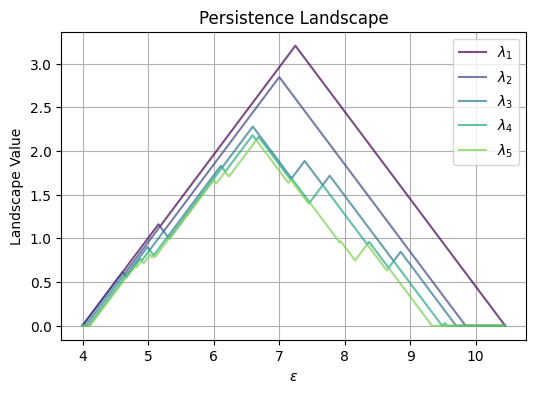

In [50]:
visualize_landscape(time_series[:-1,:], time_series[-1, :] )

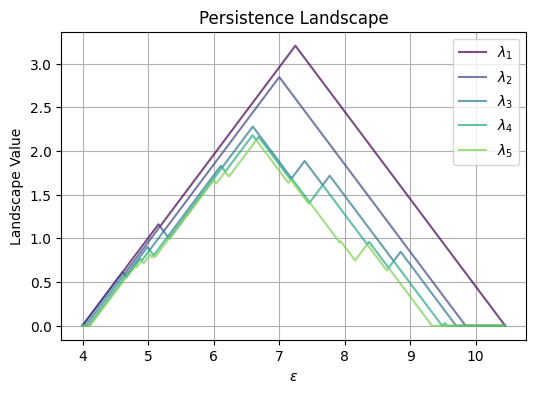

In [39]:
# Assume time_series is a NumPy array of shape (l+1, T)
# where the last row contains the epsilon (time) values.
# For example, if you already built it from your data:
# time_series = create_time_series(levels_data, trunc_level)
# Here, l = trunc_level, and T = number of unique epsilon values.

# Extract the epsilon scale (x-axis) from the last row.
time = time_series[-1, :]

# Determine the number of levels: all rows except the last one.
num_levels = time_series.shape[0] - 1

plt.figure(figsize=(6, 4))

# Generate a list of colors using a colormap (here using 'viridis').
cmap = plt.get_cmap('viridis')
colors = [cmap(i / num_levels) for i in range(num_levels)]

# Generate labels for each level using LaTeX (e.g., $\lambda_1$, $\lambda_2$, ...)
labels = [rf'$\lambda_{{{i+1}}}$' for i in range(num_levels)]

# Plot each level's landscape (each row from 0 to num_levels-1).
for lev in range(num_levels):
    plt.plot(time, time_series[lev, :], label=labels[lev], color=colors[lev], alpha=0.7)

plt.xlabel(r'$\varepsilon$')
plt.ylabel('Landscape Value')
plt.title('Persistence Landscape')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# create a fruit
fruit = fruits.Fruit("my_fruit")
# INC takes the increments of the series, i.e. x_{i+1}-x_i
fruit.add(fruits.preparation.transform.INC)

# configure the type of Iterated Sums Signature being used
# dim is the number of levels
Sigma = fruits.ISS(
    fruits.words.of_weight(2, dim=levels),
    mode=fruits.ISSMode.EXTENDED, # EXTENDED is all weights up to the specified number, and SINGLE is only the ones correpsonding to the specified weight
)
fruit.add(Sigma)
# We specify END: that we want the signature from start to end of the time series as the output of the fruit
fruit.add(fruits.sieving.END)

In [64]:
# This is how you evaluate your signature on a (tuple of) time series
fruit.fit(ts_crit_vals_all)
signature = fruit.transform(ts_crit_vals_all)

In [65]:
print(signature)

[[ 1.95340786  1.5322856   1.21906109  1.18635191  1.18454826  1.58831386
   1.24695253  1.22652993  1.22033008  1.56494145  1.33116296  1.31903412
   1.54330529  1.32125463  1.51674988  0.         -0.97670393 -2.20433041
  -2.15844692 -2.44911061 -2.70358589  0.          0.67204481 -0.79415693
  -1.20690487 -1.531049   -1.81346324  0.          0.93938583 -0.04004766
  -0.78247072 -0.90509106 -1.1165189   0.          1.2627587   0.30451907
  -0.4260719  -0.77165265 -0.90968615  0.          1.51903763  0.59313316
  -0.20251522 -0.41156848 -0.75837494]]


In [66]:
len(signature[0])

45

In [62]:
# This is the command you use to figure out what signature corresponds to what entry of the returned solution. Indices start at 0.
# fruit.label(6,'iterated sums', verbose =1)
fruit.label(354,'iterated sums', verbose =1)

'INC | [5][5][5]'

## weight 5 is too much to display! It's not too much too compute though

In [67]:
num_rows, num_cols = signature.shape

In [5]:
# num_rows, num_cols = signature.shape

# This function parses a string expression of the form "[11][23][123]"
# and returns a tensor product of monomials in the variables Z_1, Z_2, ..., Z_n.
def parse_expression(expr):
    """
    Given an expression string like "[11][23][123]",
    returns a string like "Z_{1}^{2} \\otimes Z_{2}Z_{3} \\otimes Z_{1}Z_{2}Z_{3}".
    """
    # Extract each bracketed part
    parts = re.findall(r'\[(.*?)\]', expr)
    monomials = []
    for part in parts:
        # Count the occurrences of each digit
        counts = {}
        for ch in part:
            counts[ch] = counts.get(ch, 0) + 1
        # Build the monomial string: sort the digits for consistency
        monomial_parts = []
        for digit in sorted(counts.keys()):
            exp = counts[digit]
            # If exponent is 1, we don't add a superscript.
            if exp == 1:
                monomial_parts.append(f"Z_{{{digit}}}")
            else:
                monomial_parts.append(f"Z_{{{digit}}}^{{{exp}}}")
        # Join the parts to get the monomial for this bracket
        monomials.append("".join(monomial_parts))
    # Join monomials with the tensor product symbol
    tensor_product = " \otimes ".join(monomials)
    return tensor_product

In [69]:
# num_rows, num_cols = signature.shape
# Loop over each row and column to display the information
for row in range(num_rows):
    # Create a LaTeX string for Sigma of the row; you might adjust this to your needs.
    sigma_str = f"\\Sigma(\lambda^{{ {row + 1} }})"
    
    for col in range(num_cols):
        # Retrieve the full label for the column.
        full_label = fruit.label(col, 'iterated sums', verbose=1)
        # The expected format is "INC | [expression]"; extract the part after the vertical bar.
        try:
            expr = full_label.split("|")[1].strip()  # e.g., "[11][23]"
        except IndexError:
            expr = "[]"
        
        tensor_monomials = parse_expression(expr)
        entry_value = signature[row, col]
# Print the information in the desired format:
        # \langle  \Sigma(row_i)  , tensor_of_monomials(expression of col_num) \rangle = entry_of_array(row_i,col_num)
        display(Math(f"\\langle {sigma_str}, {tensor_monomials} \\rangle = {entry_value:.2f}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Compute discrete signature

## 1. Set hyperparameters

In [1]:
# import all dependencies
import ripser
import fruits
import matplotlib.pyplot as plt
import numpy as np
import re
from IPython.display import display, Math, Latex
import os
from datetime import datetime

In [2]:
# Hyperparameters
trunc_level = 15 # landscapes will be truncated at trunc_level, or extended by 0, accordingly
weight= 2 # signatures will be computed up-to this weight, i.e. total degree

In [3]:
# Input directory
directory = "../src/ph-knotted-proteins/data/validation/landscapes/interpolated_x1"  # Replace with your directory path to the landscapes

# Get the current date and time
current_time = datetime.now().strftime('%Y%m%d_%H%M%S')

# Generate the output filename
results_filename = f'../results/tables/signature_x1_L{trunc_level}_W{weight}_{current_time}.csv'

## 2. Load and preprocess data

### 2. Option A. Load landscapes and create corresponding time series for specified 'trunc_level'
If you have already done this you can skip to Option B to load pre-processed data

In [4]:
def load_lan_file(filename, trunc_level):
    """
    Reads a .lan file and returns a list of levels truncated (or extended)
    to trunc_level.
    
    Each level is represented as a list of (epsilon, critical_value) tuples.
    The file is assumed to have header lines (starting with '#' or '%') indicating
    the beginning of a new level. Critical points for a level appear on subsequent lines.
    This is the standard format of .lan files.
    """
    levels = []
    current_points = []
    current_level_count = 0

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith('#') or line.startswith('%'):
                # Header encountered: finish the previous level if present.
                if current_points:
                    levels.append(current_points)
                    current_points = []
                    current_level_count += 1
                    if current_level_count == trunc_level:
                        break
                continue
            # Only parse data if we haven't reached the truncation limit.
            if current_level_count < trunc_level:
                tokens = line.split()
                if len(tokens) != 2:
                    raise ValueError("Expected exactly two tokens per critical point line, got: " + str(tokens))
                eps = float(tokens[0])
                val = float(tokens[1])
                current_points.append((eps, val))
    # Append any remaining points as the last level.
    if current_points and current_level_count < trunc_level:
        levels.append(current_points)
        current_level_count += 1

    # If there are fewer than trunc_level levels, extend with empty lists.
    while current_level_count < trunc_level:
        levels.append([])
        current_level_count += 1

    return levels

def eval_landscape(points, t):
    """
    Evaluate a landscape function defined by a list of (epsilon, value) tuples
    at a given epsilon value t via linear interpolation. The function is assumed 
    to be zero outside the range of the provided points.
    """
    if not points:
        return 0.0
    # t is outside the range -> return 0.
    if t < points[0][0] or t > points[-1][0]:
        return 0.0
    # Find the interval [x0, x1] in which t lies.
    for i in range(1, len(points)):
        x0, y0 = points[i-1]
        x1, y1 = points[i]
        if x0 <= t <= x1:
            if t == x0:
                return y0
            if t == x1:
                return y1
            # Linear interpolation.
            return y0 + (y1 - y0) * (t - x0) / (x1 - x0)
    return 0.0

def process_directory_to_3d(directory, trunc_level):
    """
    Processes all .lan files in the directory and returns a 3D NumPy array
    of time series data and an ordering dictionary.
    
    The output 3D array has shape (N, trunc_level, T) where:
      - N = number of landscapes (files)
      - trunc_level = number of levels per landscape (as specified)
      - T = number of unique epsilon values across all files
    The epsilon axis is common for all landscapes.
    
    Also returns:
      - ordering: a dictionary mapping each filename (without full path)
                   to its index in the 3D array.
      - global_epsilon: the sorted list of all unique epsilon values.
    """
    all_epsilons = set()
    file_list = []

    # First, gather all .lan filenames.
    for fname in os.listdir(directory):
        if fname.endswith('1.lan'):
            file_list.append(fname)
    file_list.sort()  # Ensure a consistent ordering

    # First pass: Accumulate epsilon values from all files.
    for fname in file_list:
        fpath = os.path.join(directory, fname)
        levels_data = load_lan_file(fpath, trunc_level)
        for level in levels_data:
            for (eps, _) in level:
                all_epsilons.add(eps)
    global_epsilon = sorted(all_epsilons)
    T = len(global_epsilon)

    landscapes = []    # to store the time series matrices for each file
    ordering = {}      # maps filename to its index in the 3D array

    # Second pass: For each file, evaluate the landscape at all global epsilon values.
    for idx, fname in enumerate(file_list):
        fpath = os.path.join(directory, fname)
        levels_data = load_lan_file(fpath, trunc_level)
        ts_matrix = np.zeros((trunc_level, T))
        for lev in range(trunc_level):
            pts = levels_data[lev]  # list of (eps, value) for this level (may be empty)
            for j, t in enumerate(global_epsilon):
                ts_matrix[lev, j] = eval_landscape(pts, t)
        landscapes.append(ts_matrix)
        ordering[fname] = idx

    # Stack into a 3D array: shape (N, trunc_level, T)
    result_array = np.stack(landscapes, axis=0)
    return result_array, ordering, global_epsilon

In [5]:
%%time
# Example usage:
landscape_array, ordering_dict, global_eps = process_directory_to_3d(directory, trunc_level)

print("3D Array shape (landscapes, levels, epsilon):", landscape_array.shape)
# print("Ordering dictionary (filename -> index):")
# print(ordering_dict)
# print("Global epsilon values:")
# print(global_eps)

3D Array shape (landscapes, levels, epsilon): (513, 15, 153696)
CPU times: user 16min 36s, sys: 2.74 s, total: 16min 39s
Wall time: 16min 39s


In [6]:
# (optional) Save all objects into a single .npz file
prep_land_save_filename=f'../data/prep_data_x1_L{trunc_level}.npz'
np.savez(prep_land_save_filename, 
         array_data=landscape_array, 
         vector_data=global_eps, 
         ordering_dict=ordering_dict  # Store entire dict as one object
        )
         # **ordering_dict)  # Unpacks dictionary keys as separate arrays

### 2. Option B: Load previously pre-processed data

In [12]:
# (optional) Load
prep_land_load_filename=f'../data/prep_data_x1_L{trunc_level}.npz'
loaded_data = np.load(prep_land_load_filename, allow_pickle=True)
landscape_array = loaded_data['array_data']
global_eps = loaded_data['vector_data']
ordering_dict = {k: v.item() for k, v in loaded_data['ordering_dict'].item().items()} # Critical: .item() to restore dict

## 3. Compute signatures
Use the FRUITS package to compute the discrete signatures of your set of landscapes

In [7]:
%%time
# create a fruit
fruit = fruits.Fruit("my_fruit")
# INC takes the increments of the series, i.e. x_{i+1}-x_i
fruit.add(fruits.preparation.transform.INC)

# configure the type of Iterated Sums Signature being used
# dim is the number of levels
Sigma = fruits.ISS(
    fruits.words.of_weight(weight, dim=trunc_level),
    mode=fruits.ISSMode.EXTENDED, # EXTENDED is all weights up to the specified number, and SINGLE is only the ones correpsonding to the specified weight
)
fruit.add(Sigma)
# We specify END: that we want the signature from start to end of the time series as the output of the fruit
fruit.add(fruits.sieving.END)

CPU times: user 18.6 ms, sys: 998 µs, total: 19.6 ms
Wall time: 19.1 ms


In [8]:
%%time
# Example usage: This is how you evaluate your signature on a (tuple of) time series
fruit.fit(landscape_array)
signature = fruit.transform(landscape_array) # this variable stores the computed signature(s)

In [9]:
fruit.summary()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


"================================================================================\n<                      Fruit 'my_fruit' -> Features: 360                       >\n================================================================================\n|--------------------------------------|\n|          FruitSlice -> 360           |\n|--------------------------------------|\n|Preparateurs (1):                     |\n|    + INC(1, 1, True)                 |\n|ISS Calculators (1):                  |\n|    + ISS -> 360                      |\n|       | words: 345                   |\n|       | semiring: Reals              |\n|       | weighting: None              |\n|Sieves (1):                           |\n|    + END -> 1                        |\n|--------------------------------------|\n================================================================================"

In [17]:
# This function parses a string expression of the form "[11][23][123]"
# and returns a tensor product of monomials in the variables Z_1, Z_2, ..., Z_n.
def parse_expression(expr):
    """
    Given an expression string like "[11][23][123]",
    returns a string like "Z_{1}^{2} \\otimes Z_{2}Z_{3} \\otimes Z_{1}Z_{2}Z_{3}".
    """
    # Extract each bracketed part
    parts = re.findall(r'\[(.*?)\]', expr)
    monomials = []
    for part in parts:
        # Count the occurrences of each digit
        counts = {}
        for ch in part:
            counts[ch] = counts.get(ch, 0) + 1
        # Build the monomial string: sort the digits for consistency
        monomial_parts = []
        for digit in sorted(counts.keys()):
            exp = counts[digit]
            # If exponent is 1, we don't add a superscript.
            if exp == 1:
                monomial_parts.append(f"Z_{{{digit}}}")
            else:
                monomial_parts.append(f"Z_{{{digit}}}^{{{exp}}}")
        # Join the parts to get the monomial for this bracket
        monomials.append("".join(monomial_parts))
    # Join monomials with the tensor product symbol
    tensor_product = " \otimes ".join(monomials)
    return tensor_product

In [36]:
from IPython.display import Math, display

num_rows, num_cols = signature.shape

# Loop over each row and column to display the information
for row in range(num_rows):
    # Create a LaTeX string for Sigma of the row; you might adjust this to your needs.
    sigma_str = f"\\Sigma(\lambda^{{ {row + 1} }})"
    
    for col in range(num_cols):
        # Retrieve the full label for the column.
        full_label = fruit.label(col, 'iterated sums', verbose=1)
        # The expected format is "INC | [expression]"; extract the part after the vertical bar.
        try:
            expr = full_label.split("|")[1].strip()  # e.g., "[11][23]"
        except IndexError:
            expr = "[]"
        
        tensor_monomials = parse_expression(expr)
        entry_value = signature[row, col]
        
        # Print the information in the desired format:
        # \langle  \Sigma(row_i)  , tensor_of_monomials(expression of col_num) \rangle = entry_of_array(row_i,col_num)
        # Use scientific notation for small numbers
        if abs(entry_value) < 1e-4:
            entry_str = f"{entry_value:.4e}"  # Scientific notation for small numbers
        else:
            entry_str = f"{entry_value:.4f}"  # Regular decimal notation for larger numbers
        
        display(Math(f"\\langle {sigma_str}, {tensor_monomials} \\rangle = {entry_str}"))

### 3.1. Store the results in a dataframe

In [10]:
%%time
import pandas as pd

# Initialize a list to store the data
data = []

num_rows, num_cols = signature.shape

# Loop over each row (landscape) and column (expression)
for row in range(num_rows):
    landscape_number = row + 1  # Landscape numbering starts at 1
    landscape_data = {"Landscape": landscape_number}  # Initialize a dictionary for this landscape
    
    for col in range(num_cols):
        # Retrieve the full label for the column
        full_label = fruit.label(col, 'iterated sums', verbose=1)
        
        # Extract the expression (e.g., "[11][23]")
        try:
            expr = full_label.split("|")[1].strip()
        except IndexError:
            expr = "[]"
        
        # Get the value of the signature entry
        entry_value = signature[row, col]
        
        # Store the value in the dictionary
        landscape_data[expr] = entry_value

    # Append the landscape data to the list
    data.append(landscape_data)

# Convert the list to a DataFrame
df = pd.DataFrame(data)

CPU times: user 9.27 s, sys: 20.5 ms, total: 9.29 s
Wall time: 9.43 s


In [11]:
# Swap keys and values
corrected_dictionary = {v: k for k, v in ordering_dict.items()}

dict_df = pd.DataFrame.from_dict(corrected_dictionary, orient='index', columns=['Chain'])

# Extract the part before the first underscore
dict_df['Chain'] = dict_df['Chain'].str.split('_').str[:2].str.join('_')

# Glue the dataframes so that we also have the knot labels associated to the landscape number
df = dict_df.join(df)

Save the dataframe

In [12]:
# Save the DataFrame to 'results_filename' specified at the beginning of the notebook
df.to_csv(results_filename, index=False)

print(f"Data saved to {results_filename}")

Data saved to ../results/tables/signature_x1_L15_W2_20250425_191619.csv


## 4.(OPTIONAL) Display signatures and visualize landscapes
The functions bellow allow you to explore the data and results by displaying signatures following the notation used in the paper, or plotting truncated landscapes

### Now we display in a flexible way by accessing the dataframe

In [21]:
# This function parses a string expression of the form "[11][23][123]"
# and returns a tensor product of monomials in the variables Z_1, Z_2, ..., Z_n.
def parse_expression(expr):
    """
    Given an expression string like "[11][23][123]",
    returns a string like "Z_{1}^{2} \\otimes Z_{2}Z_{3} \\otimes Z_{1}Z_{2}Z_{3}".
    """
    # Extract each bracketed part
    parts = re.findall(r'\[(.*?)\]', expr)
    monomials = []
    for part in parts:
        # Count the occurrences of each digit
        counts = {}
        for ch in part:
            counts[ch] = counts.get(ch, 0) + 1
        # Build the monomial string: sort the digits for consistency
        monomial_parts = []
        for digit in sorted(counts.keys()):
            exp = counts[digit]
            # If exponent is 1, we don't add a superscript.
            if exp == 1:
                monomial_parts.append(f"Z_{{{digit}}}")
            else:
                monomial_parts.append(f"Z_{{{digit}}}^{{{exp}}}")
        # Join the parts to get the monomial for this bracket
        monomials.append("".join(monomial_parts))
    # Join monomials with the tensor product symbol
    tensor_product = " \otimes ".join(monomials)
    return tensor_product

In [22]:
from IPython.display import Math, display

def display_signatures(df, landscapes=None, expressions=None):
    """
    Display the signatures in a formatted way.
    
    Parameters:
    - df: The DataFrame containing the signature data.
    - landscapes: A list of landscape numbers to display (e.g., [1, 2]). If None, all landscapes are displayed.
    - expressions: A list of expressions to display (e.g., ["[11][23]", "[12][34]"]). If None, all expressions are displayed.
    """
    # Filter by landscapes
    if landscapes is not None:
        df = df[df['Landscape'].isin(landscapes)]
    
    # Filter by expressions
    if expressions is not None:
        df = df[['Landscape'] + expressions]
    
    # Loop over each row (landscape) and column (expression)
    for _, row in df.iterrows():
        landscape_number = row['Landscape']
        for expr, value in row.items():
            if expr == 'Landscape':
                continue  # Skip the 'Landscape' column
            
            # Format the value
            if abs(value) < 1e-4:
                value_str = f"{value:.4e}"  # Scientific notation for small numbers
            else:
                value_str = f"{value:.4f}"  # Regular decimal notation for larger numbers
            
            # Display the formatted output
            display(Math(f"\\langle \\Sigma(\\lambda^{{ {int(landscape_number)} }}), {parse_expression(expr)} \\rangle = {value_str}"))

In [23]:
# Example usage
# Display all signatures
# display_signatures(df)

# Display signatures for specific landscapes
# display_signatures(df, landscapes=[1, 2])

# Display signatures for specific expressions
# display_signatures(df, expressions=["[1][23]", "[2][34]"])

# Display signatures for specific landscapes and expressions
display_signatures(df, landscapes=[1, 2, 98], expressions=["[1][3]", "[23]"])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### You can use the function below to visualize any landscape from your dataset, truncated at the selected 'trunc_level'

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_landscape(time_series, time = global_eps, figsize=(6, 4), title='Persistence Landscape'):
    """
    Visualize a persistence landscape given its time-series representation.
    
    Parameters:
      time_series : numpy.ndarray
          A NumPy array of shape (l+1, T) where the last row contains the 
          epsilon (time) values and the first l rows contain the landscape levels.
      figsize : tuple, optional
          Figure size for the plot (default is (6, 4)).
      title : str, optional
          Title of the plot.
    """
    # Extract the epsilon scale (x-axis) from the last row.
    # time = time_series[-1, :]

    # Determine the number of levels: all rows except the last one.
    num_levels = time_series.shape[0]

    plt.figure(figsize=figsize)

    # Generate a list of colors using a colormap (here using 'viridis').
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / num_levels) for i in range(num_levels)]

    # Generate labels for each level using LaTeX (e.g., $\lambda_1$, $\lambda_2$, ...)
    labels = [rf'$\lambda_{{{i+1}}}$' for i in range(num_levels)]

    # Plot each level's landscape (each row from 0 to num_levels-1).
    for lev in range(num_levels):
        plt.plot(time, time_series[lev, :], label=labels[lev], color=colors[lev], alpha=0.7)

    plt.xlabel(r'$\varepsilon$')
    plt.ylabel('Landscape Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

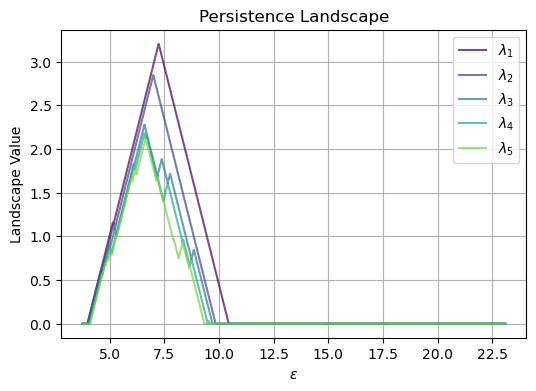

In [25]:
# example usage
visualize_landscape(landscape_array[0,:,:], global_eps)